**Install Unsloth for LLM fine-tuning and Initialize base model.**

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install unsloth
# Get latest Unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [ ]:
from unsloth import FastLanguageModel
import torch
from google.colab import drive

# Model name and path
model_names = ["DPO fine-tuned model", "supervised and DPO fine-tuned model"]
model_name_paths = ["supervised_fine_tuned_model", "STF_and_DPO_model"]

target_model_name = ""
model_name_path = ""

# Fine-tuning parameters
max_seq_length = 2048
dtype = None
# Use 4bit quantization to reduce memory usage.
load_in_4bit = True
# Enable combined supervised and DPO fine-tuning
is_STF_and_DPO_fine_tuned = True

# Dataset format
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
] # More models at https://huggingface.co/unsloth

# Retrieve previously supervised fine-tuned model
if is_STF_and_DPO_fine_tuned == True:
  target_model_name = model_names[1]
  model_name_path = model_name_paths[1]

  drive.mount('/content/drive')

  model, tokenizer = FastLanguageModel.from_pretrained(
      model_name = f"/content/drive/My Drive/Fine_tuned_model/supervised_fine_tuned_model",
      max_seq_length = max_seq_length,
      dtype = dtype,
      load_in_4bit = load_in_4bit,
  )
else:
    target_model_name = model_names[0]
    model_name_path = model_name_paths[0]

    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "unsloth/Meta-Llama-3.1-8B-bnb-4bit", # or choose "unsloth/Llama-3.2-1B-Instruct"
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
==((====))==  Unsloth 2024.9.post4: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2024.9.post4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


**Preparing the custom dataset to fine-tune the base model**

After loading the dataset, first sample of the dataset will be printed

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("quangduc1112001/python-code-DPO-fine-tune", split="train")

val_dataset = load_dataset("quangduc1112001/python-code-DPO-fine-tune", split="validation")

Generating train split:   0%|          | 0/1800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/200 [00:00<?, ? examples/s]

**Utilizing LoRA adapter to fine-tune LLM more efficiently and effectively.**

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    # ranking number
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,  # Support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: Already have LoRA adapters! We shall skip this step.


**Start fine-tuning the base model with DPO**

**Initialize the Direct Preference Optimization (DPO) trainer**

In [ ]:
from unsloth import PatchDPOTrainer
PatchDPOTrainer()

In [ ]:
from transformers import TrainingArguments
from trl import DPOTrainer, DPOConfig

dpo_trainer = DPOTrainer(
    model = model,
    ref_model = None,

    args = DPOConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_ratio = 0.1,
        num_train_epochs = 3,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.0,
        lr_scheduler_type = "linear",
        seed = 42,
        output_dir = "outputs",

        fp16_full_eval = True,
        per_device_eval_batch_size = 2,
        eval_accumulation_steps = 1,
        eval_strategy = "steps",
        eval_steps = 60,
    ),

    beta = 0.1,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    tokenizer = tokenizer,
    max_length = max_seq_length,
    max_prompt_length = max_seq_length,
)

trainer_stats = dpo_trainer.train()

Tokenizing train dataset:   0%|          | 0/1800 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,800 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 675
 "-____-"     Number of trainable parameters = 41,943,040
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / rejected,logps / chosen,logits / rejected,logits / chosen
60,0.193100,0.104345,1.332725,-8.702673,0.910000,10.035398,-146.659058,-80.837814,-0.553996,-0.436138
120,0.109900,0.102944,0.736655,-12.020849,0.910000,12.757504,-179.840820,-86.798508,-0.314797,-0.223749
180,0.234500,0.219212,-0.666846,-11.256339,0.900000,10.589494,-172.195724,-100.833527,-0.621329,-0.547424
240,0.000300,0.081661,0.040049,-12.323154,0.915000,12.363203,-182.863892,-93.764580,-0.085768,-0.113380
300,0.000100,0.080802,1.151259,-10.420108,0.920000,11.571366,-163.833420,-82.652458,-0.171513,-0.159345
360,0.086700,0.110830,-1.962755,-18.173647,0.910000,16.210892,-241.368805,-113.792618,-0.064723,-0.206349
420,0.000000,0.089447,-0.822921,-17.005234,0.925000,16.182310,-229.684647,-102.394279,-0.304385,-0.344327
480,0.087100,0.091404,-1.176394,-18.587313,0.920000,17.410917,-245.505432,-105.929001,-0.206373,-0.282910
540,0.000100,0.090052,-0.621232,-18.845362,0.915000,18.224131,-248.085938,-100.377373,-0.114730,-0.191066
600,0.086600,0.088820,-0.729126,-19.197021,0.915000,18.467897,-251.602539,-101.456329,-0.098267,-0.183902


**Save and retrieve the saved model.**

In [ ]:
from google.colab import drive

model_name = "DPO_fine_tuned_model"

if False:
  drive.mount('/content/drive')

  # Save the model to your Drive
  model.save_pretrained(f"/content/drive/My Drive/Fine_tuned_model/{model_name_path}")
  tokenizer.save_pretrained(f"/content/drive/My Drive/Fine_tuned_model/{model_name_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if False:
  # Load the model from your Drive
  from unsloth import FastLanguageModel
  model, tokenizer = FastLanguageModel.from_pretrained(
      model_name = f"/content/drive/My Drive/Fine_tuned_model/{model_name_path}",
      max_seq_length = max_seq_length,
      dtype = dtype,
      load_in_4bit = load_in_4bit,
  )

**Load dataset to test LLM's performance**

In [ ]:
# Initialize EOS token
EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

In [2]:
import json
from google.colab import drive

use_local_dataset = True

test_dataset = {}

if use_local_dataset:
  drive.mount('/content/drive')

  file_path = '/content/drive/My Drive/fine_tune_data_utils/test_dataset_100.json'

  with open(file_path, 'r') as f:
    data = json.load(f)

  for i in range(len(data)):
    test_dataset[i] = data[str(i)]

else:
  test_dataset = load_dataset("flytech/python-codes-25k", split = "train")
  test_dataset = test_dataset.map(formatting_prompts_func, batched = True,)

Mounted at /content/drive


**Test the fine-tuned LLM model with codeBERT score**

In [3]:
!pip install code-bert-score

  Preparing metadata (setup.py) ... done
  Created wheel for code-bert-score: filename=code_bert_score-0.4.1-py3-none-any.whl size=22071 sha256=7581f00ad29801c9da06eb82a7433a67a528586f42aa27b3dd340b25c6073e87
  Stored in directory: /root/.cache/pip/wheels/26/ea/cb/0ddb50c1baacd77c6ea15e3df5862070bee90e7e9bef2150d0
Successfully built code-bert-score


In [4]:
from transformers import TextStreamer
import re
import numpy as np

# Function to extract the response part
def extract_response(generated_text):
    cleaned_text = generated_text.replace("<|end_of_text|>", "")

    match = re.search(r"### Response:\n([\s\S]+)", cleaned_text)

    if match:
        return match.group(1).strip()
    return cleaned_text

current_output = 0

# Function to generate outputs for the test dataset
def generate_outputs(dataset, model, tokenizer):
    global current_output
    outputs = []

    for item in dataset.values():
        inputs = tokenizer(
            [alpaca_prompt.format(item['instruction'], item['input'], "")],
            return_tensors="pt"
        ).to("cuda")

        # Generate output from the model
        text_streamer = TextStreamer(tokenizer)
        generated_outputs = model.generate(**inputs, max_new_tokens=max_seq_length)
        generated_text = tokenizer.decode(generated_outputs[0], skip_special_tokens=False)

        response = extract_response(generated_text)

        # Append the generated output to the list
        outputs.append(response)

        current_output +=1
        print(f"Progress: {current_output}/{total_output}")

    return outputs

In [6]:
from code_bert_score import score
import matplotlib.pyplot as plt

# Debug parameter
is_test_dataset_truncated = True
truncate_amount = 100
chosen_dataset = {}

# Generate outputs for the test dataset
is_load_from_local = True
test_outputs = []

if is_test_dataset_truncated == True:
  custom_dict = {}
  for i in range(truncate_amount):
    custom_dict[i] = test_dataset[i]
  chosen_dataset = custom_dict
else:
  custom_dict = {}
  for i in range(len(test_dataset)):
    custom_dict[i] = test_dataset[i]
  chosen_dataset = custom_dict

total_output = len(chosen_dataset)

# Extracting the 'output' field from the test dataset into a separate list
output_field_list = [item["output"] for item in chosen_dataset.values()]

# Generate outputs for the test dataset
current_output = 0

if is_load_from_local == True:
  drive.mount('/content/drive')

  file_path = '/content/drive/My Drive/fine_tune_data_utils/STF_DPO_model_test_output.json'

  with open(file_path, 'r') as f:
    data = json.load(f)

  test_outputs = data
else:
  FastLanguageModel.for_inference(model)

  test_outputs = generate_outputs(chosen_dataset, model, tokenizer)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
print(test_outputs[0])

def add_sequence(numbers):
  return (len(numbers) == 0)
   ? 0
    : (max(numbers) - min(numbers) + 1) *
      (min(numbers) + (max(numbers) // 2))

numbers = [1, 2, 3, 4, 5]
result = add_sequence(numbers)
print(result) # 15


In [ ]:
import json
from google.colab import files

# Save DPO fine-tuned model test ouput
if False:
  data = test_outputs
  filename = f'{model_name_path}.json'
  with open(filename, 'w') as json_file:
      json.dump(data, json_file, indent=4)

  # Download the file
  files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save test dataset used to test model
if False:
  data = test_dataset
  filename = 'test_dataset_100.json'
  with open(filename, 'w') as json_file:
      json.dump(data, json_file, indent=4)

  # Download the file
  files.download(filename)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Mean level F1 score of supervised and DPO fine-tuned model LLM: 0.831
Median level F1 score of supervised and DPO fine-tuned model LLM: 0.828
Variance level F1 score of supervised and DPO fine-tuned model LLM: 0.004
Standard deviation level F1 score of supervised and DPO fine-tuned model LLM: 0.066
------------------
Mean level F3 score of supervised and DPO fine-tuned model LLM: 0.834
Median level F3 score of supervised and DPO fine-tuned model LLM: 0.834
Variance level F3 score of supervised and DPO fine-tuned model LLM: 0.005
Standard deviation level F3 score of supervised and DPO fine-tuned model LLM: 0.072


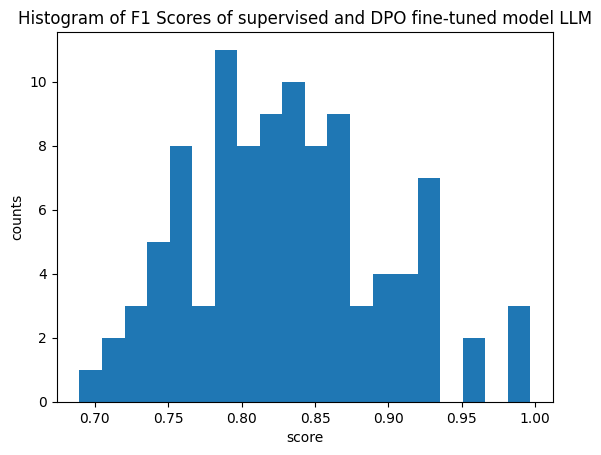

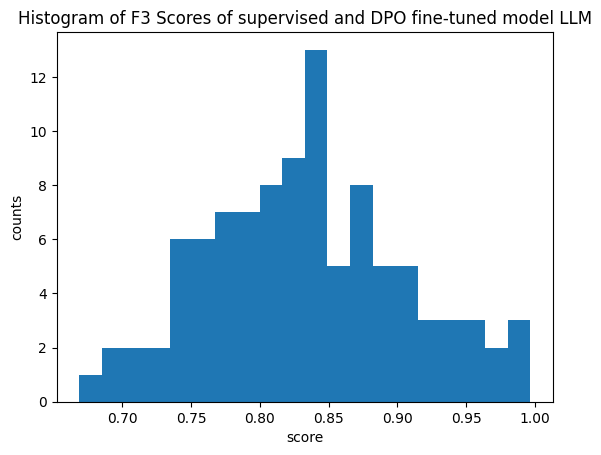

In [10]:
# Calculate score
P, R, F1, F3 = score(cands=test_outputs, refs=output_field_list, lang='python')

F1 = np.array(F1)
F3 = np.array(F3)
P = np.array(P)
R = np.array(R)
print(f"Mean level F1 score of {target_model_name} LLM: {F1.mean():.3f}")
print(f"Median level F1 score of {target_model_name} LLM: {np.median(F1):.3f}")
print(f"Variance level F1 score of {target_model_name} LLM: {np.var(F1):.3f}")
print(f"Standard deviation level F1 score of {target_model_name} LLM: {np.std(F1):.3f}")
print("------------------")
print(f"Mean level F3 score of {target_model_name} LLM: {F3.mean():.3f}")
print(f"Median level F3 score of {target_model_name} LLM: {np.median(F3):.3f}")
print(f"Variance level F3 score of {target_model_name} LLM: {np.var(F3):.3f}")
print(f"Standard deviation level F3 score of {target_model_name} LLM: {np.std(F3):.3f}")

plt.hist(F1, bins=20)
plt.title(f"Histogram of F1 Scores of {target_model_name} LLM")
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

plt.hist(F3, bins=20)
plt.title(f"Histogram of F3 Scores of {target_model_name} LLM")
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

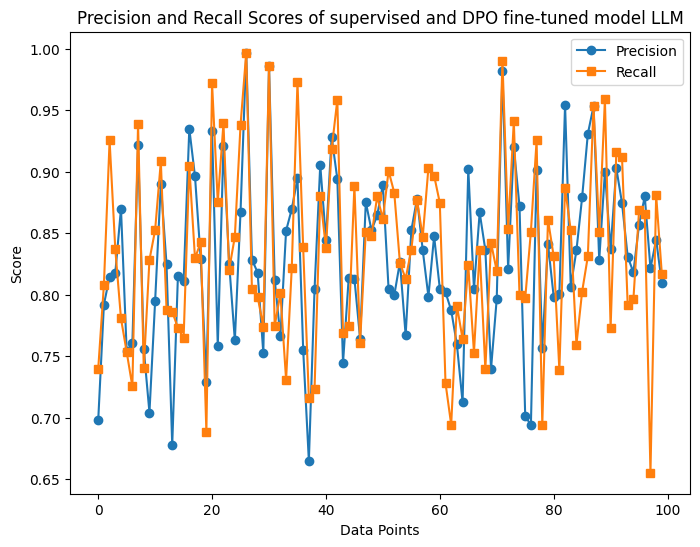

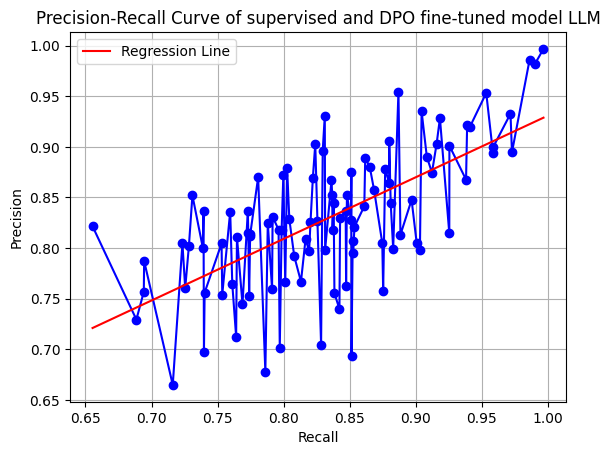

Slope: 0.608
Intercept: 0.322


In [11]:
plt.figure(figsize=(8, 6))

# Plot precision and recall
plt.plot(P, label='Precision', marker='o')
plt.plot(R, label='Recall', marker='s')

# Add labels and title
plt.xlabel('Data Points')
plt.ylabel('Score')
plt.title(f'Precision and Recall Scores of {target_model_name} LLM')

# Add legend
plt.legend()

# Display the plot
plt.show()

# Create a sorted array based on recall (inverse_recall)
sorted_indices = np.argsort(R)
sorted_recall = R[sorted_indices]
sorted_precision = P[sorted_indices]

# Create the plot
plt.grid(True)
plt.plot(sorted_recall, sorted_precision, marker='o', color='b')

# Add labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve of {target_model_name} LLM")

# Regress a line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(sorted_recall, sorted_precision)
x_reg = np.linspace(sorted_recall.min(), sorted_recall.max(), 100)
y_reg = slope * x_reg + intercept

plt.plot(x_reg, y_reg, color='r', label='Regression Line')

plt.legend()

# Show the plot
plt.show()

print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")

**Test the fine-tuned LLM model with BERT score**

In [12]:
!pip install bert-score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.2 MB/s eta 0:00:00


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 9.70 seconds, 10.31 sentences/sec
Mean level F1 score of supervised and DPO fine-tuned model LLM: 0.890
Median level F1 score of supervised and DPO fine-tuned model LLM: 0.886
Variance level F1 score of supervised and DPO fine-tuned model LLM: 0.001
Standard deviation level F1 score of supervised and DPO fine-tuned model LLM: 0.034


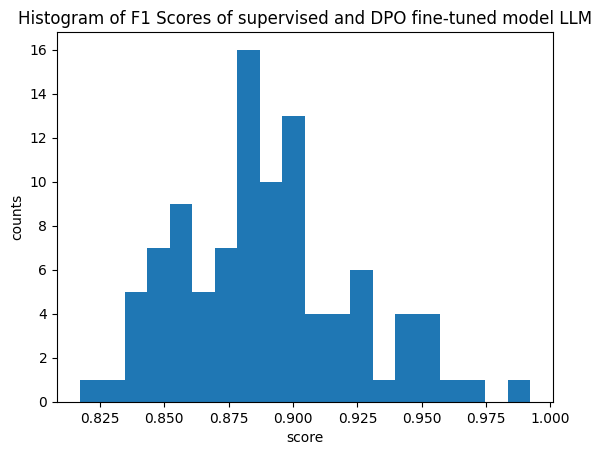

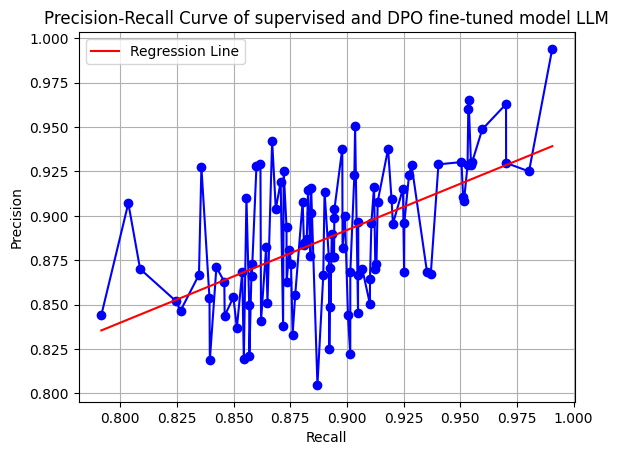

Slope: 0.521
Intercept: 0.423


In [13]:
from bert_score import score

P, R, F1 = score(cands=test_outputs, refs=output_field_list, lang='en', verbose=True)

F1 = np.array(F1)
P = np.array(P)
R = np.array(R)
print(f"Mean level F1 score of {target_model_name} LLM: {F1.mean():.3f}")
print(f"Median level F1 score of {target_model_name} LLM: {np.median(F1):.3f}")
print(f"Variance level F1 score of {target_model_name} LLM: {np.var(F1):.3f}")
print(f"Standard deviation level F1 score of {target_model_name} LLM: {np.std(F1):.3f}")

plt.hist(F1, bins=20)
plt.title(f"Histogram of F1 Scores of {target_model_name} LLM")
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

# Create a sorted array based on recall (inverse_recall)
sorted_indices = np.argsort(R)
sorted_recall = R[sorted_indices]
sorted_precision = P[sorted_indices]

# Create the plot
plt.grid(True)
plt.plot(sorted_recall, sorted_precision, marker='o', color='b')

# Add labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve of {target_model_name} LLM")

# Regress a line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(sorted_recall, sorted_precision)
x_reg = np.linspace(sorted_recall.min(), sorted_recall.max(), 100)
y_reg = slope * x_reg + intercept

plt.plot(x_reg, y_reg, color='r', label='Regression Line')

plt.legend()

# Show the plot
plt.show()

print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")

**Test fine-tuned LLM model with BLEU score**

In [14]:
!pip install nltk

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Mean BLEU score of supervised and DPO fine-tuned model LLM: 0.124
Median BLEU score of supervised and DPO fine-tuned model LLM: 0.000
Variance BLEU score of supervised and DPO fine-tuned model LLM: 0.033
Standard deviation BLEU score of supervised and DPO fine-tuned model LLM: 0.181


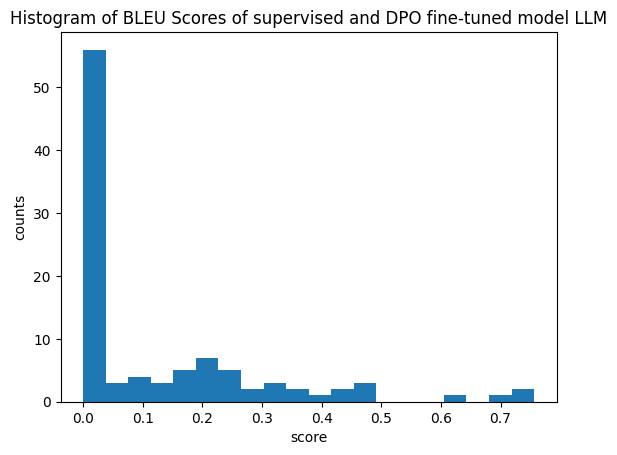

In [15]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

references = []

for item in output_field_list:
  references.append([item.split()])

BLEU = []

for i in range(len(test_outputs)):
    score = sentence_bleu(references[i], test_outputs[i].split())
    BLEU.append(score)

BLEU = np.array(BLEU)

print(f"Mean BLEU score of {target_model_name} LLM: {BLEU.mean():.3f}")
print(f"Median BLEU score of {target_model_name} LLM: {np.median(BLEU):.3f}")
print(f"Variance BLEU score of {target_model_name} LLM: {np.var(BLEU):.3f}")
print(f"Standard deviation BLEU score of {target_model_name} LLM: {np.std(BLEU):.3f}")

plt.hist(BLEU, bins=20)
plt.title(f"Histogram of BLEU Scores of {target_model_name} LLM")
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

**Test fine-tuned LLM model with codeBLEU score**

In [16]:
!pip install codebleu
!pip install tree-sitter-python==0.21

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.6/542.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.6/130.6 kB 4.9 MB/s eta 0:00:00


In [17]:
from codebleu import calc_codebleu

code_BLEU_results = calc_codebleu(output_field_list, test_outputs, lang="python", weights=(0.25, 0.25, 0.25, 0.25))
code_BLEU = code_BLEU_results['codebleu']

print(f"codeBLEU score of {target_model_name} LLM: {code_BLEU:.3f}")

codeBLEU score of supervised and DPO fine-tuned model LLM: 0.253
